In [1]:
import datetime
import scipy.optimize as sco

import typing
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import scipy as sp
import pandas_datareader as pd_data

warnings.filterwarnings('ignore')

In [2]:
def Portfolio_stats(weights: "porportions of capital", 
                    expRtns: "LIBOR rates & forecasted returns", 
                    cov: "covariance based on historical data", 
                    mu_f: "US treasury yield") -> "portfolio returns,variance,volatility,sharpe_ratio":
    varP = np.dot(weights.T, np.dot(cov,weights))
    volP = np.sqrt(varP)
    rtnP = np.sum(weights*expRtns)
    sharpeP = (rtnP-mu_f)/volP
    return rtnP, varP, volP, sharpeP

def negative_sharpe(weights):
    return -Portfolio_stats(weights,expRtns,cov,mu_f)[3]

def returns_from_prices(prices, log_returns=False):
    """
    Calculate the returns given prices.
    :param prices: adjusted (daily) closing prices of the asset, each row is a
                   date and each column is a ticker/id.
    :type prices: pd.DataFrame
    :param log_returns: whether to compute using log returns
    :type log_returns: bool, defaults to False
    :return: (daily) returns
    :rtype: pd.DataFrame
    """
    if log_returns:
        return np.log(prices).diff().dropna(how="all")
    else:
        return prices.pct_change().dropna(how="all")
        
def _pair_exp_cov(X, Y, span=180):
    """
    Calculate the exponential covariance between two timeseries of returns.
    :param X: first time series of returns
    :type X: pd.Series
    :param Y: second time series of returns
    :type Y: pd.Series
    :param span: the span of the exponential weighting function, defaults to 180
    :type span: int, optional
    :return: the exponential covariance between X and Y
    :rtype: float
    """
    covariation = (X - X.mean()) * (Y - Y.mean())
    # Exponentially weight the covariation and take the mean
    if span < 10:
        warnings.warn("it is recommended to use a higher span, e.g 30 days")
    return covariation.ewm(span=span).mean().iloc[-1]     

def exp_cov(prices, returns_data=False, span=180, frequency=252, **kwargs):
    """
    Estimate the exponentially-weighted covariance matrix, which gives
    greater weight to more recent data.
    :param prices: adjusted closing prices of the asset, each row is a date
                   and each column is a ticker/id.
    :type prices: pd.DataFrame
    :param returns_data: if true, the first argument is returns instead of prices.
    :type returns_data: bool, defaults to False.
    :param span: the span of the exponential weighting function, defaults to 180
    :type span: int, optional
    :param frequency: number of time periods in a year, defaults to 252 (the number
                      of trading days in a year)
    :type frequency: int, optional
    :return: annualised estimate of exponential covariance matrix
    :rtype: pd.DataFrame
    """
    if not isinstance(prices, pd.DataFrame):
        warnings.warn("data is not in a dataframe", RuntimeWarning)
        prices = pd.DataFrame(prices)
    assets = prices.columns
    if returns_data:
        returns = prices
    else:
        returns = returns_from_prices(prices)
    N = len(assets)

    # Loop over matrix, filling entries with the pairwise exp cov
    S = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            S[i, j] = S[j, i] = _pair_exp_cov(
                returns.iloc[:, i], returns.iloc[:, j], span
            )
    cov = pd.DataFrame(S * frequency, columns=assets, index=assets)
    return cov

In [3]:
# import LIBOR rates data
LIBOR_rates = pd.read_csv("LIBOR_USD.csv")

# convert to datetime
LIBOR_rates['Date'] = pd.to_datetime(LIBOR_rates['Date'],format="%d.%m.%Y")

In [4]:
# import US Treasury yield data
TreasuryYields = pd.read_csv('USTREASURY_YIELD.csv')

# convert to datetime
TreasuryYields['Date']= pd.to_datetime(TreasuryYields['Date'],format="%Y-%m-%d")

In [13]:
start_date = datetime.datetime(2015, 9, 1) # fixed
date_range = pd.date_range(start='1/1/2017', periods=12, freq='M') # evolving - hypothetically the current time

delta1 = datetime.timedelta(days=30)
delta2 = datetime.timedelta(days=365)

symbols = ['AAPL', 'GS', 'GC=F', 'GE', 'TSLA']

In [17]:
results = []

In [18]:
for end_date in date_range:
    # PROBLEM: end_date might not be a trading day (need a trading calender)
    ahead_date = end_date + datetime.timedelta(days=365)

    # historical data: to be used to compute covariance
    df = pd_data.DataReader(symbols,'yahoo',start_date,end_date)['Adj Close'] 
    df = df.dropna()

    # one-year-ahead data: to be used as the (fake) forecasted return
    df2 = pd_data.DataReader(symbols,'yahoo',end_date,ahead_date)['Adj Close'] 
    df2 = df2.dropna()
    
    # LIBOR rates between start date & end date
    Rates = LIBOR_rates.loc[ (LIBOR_rates['Date'] >= start_date) & (LIBOR_rates['Date'] <= end_date) ]
    Rates.sort_values(by='Date',ascending=True,inplace=True)
    Rates.set_index('Date',inplace=True)
    ON_rates = Rates['ON']/100/252
    
    # compute covariance
    df_all = df.copy()
    df_all['Cash'] = ON_rates # Overnight LIBOR from start date to end date
    df_all = df_all.dropna()
    dfrtn_all = df_all.pct_change().dropna() # the percentage (not log) returns of stocks
    cov = exp_cov(dfrtn_all, returns_data = True) # covariance of percentage returns
    
    # compute expected returns
    expRtns = df2.pct_change().mean(axis=0)
    expRtns['Cash'] = ON_rates.iloc[-1] # the current Overnight LIBOR
    
    # assuming portfolio holding period = 3 years
    # the current treasury yield
    yields = TreasuryYields.loc[ (TreasuryYields['Date'] >= end_date-datetime.timedelta(days=7)) 
                                & (TreasuryYields['Date'] <= end_date) ] 
                                # to solve the problem when end_date is not a trading day
                                # take the data from the last available date
    Y3_yields = yields['3 YR']/100/252
    mu_f = Y3_yields.iloc[-1]
    
    #################################################
    # compute optimal weights based on Sharpe Ratio #
    #################################################
    
    nn = len(expRtns) # total number of stocks (+cash)

    w0 = [1.0/nn for i in range(nn)]# Initialise weights
    w0 = np.array(w0)

    # constraints on weights
    cons = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #add up to 1
    bnds = tuple((0,1) for x in range(nn)) #only between 0 and 1, i.e. no short-selling

    # maximise sharpe ratio = minimise negative sharpe ratio
    opts = sco.minimize(negative_sharpe, w0 , method = 'SLSQP', bounds= bnds, constraints = cons)

    # optimal weights
    opt_w = opts['x'].round(3)
    print('Optimal weights on',end_date.date(),'is',opt_w)
    results.append(opt_w)


Optimal weights on 2017-01-31 is [0.388 0.15  0.339 0.    0.11  0.014]
Optimal weights on 2017-02-28 is [0.465 0.085 0.272 0.    0.165 0.014]
Optimal weights on 2017-03-31 is [0.46  0.181 0.359 0.    0.    0.   ]
Optimal weights on 2017-04-30 is [0.496 0.141 0.363 0.    0.    0.   ]
Optimal weights on 2017-05-31 is [0.664 0.061 0.275 0.    0.    0.   ]
Optimal weights on 2017-06-30 is [0.823 0.    0.167 0.    0.    0.009]
Optimal weights on 2017-07-31 is [0.978 0.011 0.004 0.    0.    0.006]
Optimal weights on 2017-08-31 is [0.991 0.    0.    0.    0.    0.009]
Optimal weights on 2017-09-30 is [0.999 0.    0.001 0.    0.    0.   ]
Optimal weights on 2017-10-31 is [0.973 0.    0.    0.    0.022 0.005]
Optimal weights on 2017-11-30 is [0.312 0.    0.    0.    0.688 0.   ]
Optimal weights on 2017-12-31 is [0.    0.    0.    0.    0.997 0.003]


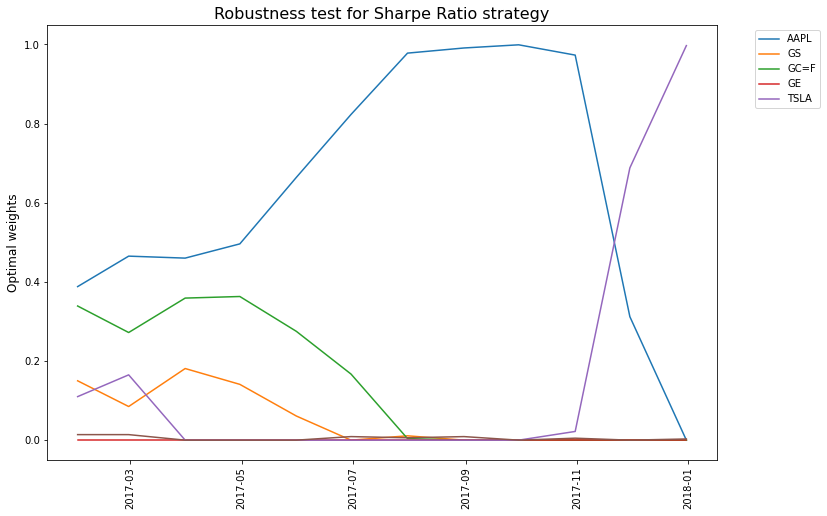

In [19]:
plt.rcParams["figure.figsize"] = (12,8)
results_arr = np.stack(results, axis=0)
plt.plot(date_range, results_arr)
plt.xticks(rotation=90)
plt.legend(symbols,bbox_to_anchor=(1.05, 1),loc='upper left')
plt.ylabel('Optimal weights',size=12)
plt.title('Robustness test for Sharpe Ratio strategy',size=16)
plt.show()